# Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [3]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [4]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [5]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [17]:
df1=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/Brent Spot Price.csv')

In [18]:
df1.head()

,Unnamed: 0,"Brent crude oil spot price, Monthly (dollars per barrel)"
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


In [19]:
df1.rename(columns={'Unnamed: 0':'Year-Month','Brent crude oil spot price, Monthly (dollars per barrel)':'Price'}, inplace=True)
df1.head()

,Year-Month,Price
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


In [20]:
df=df1['Price']

# Q1) Figure Showing plot of the data

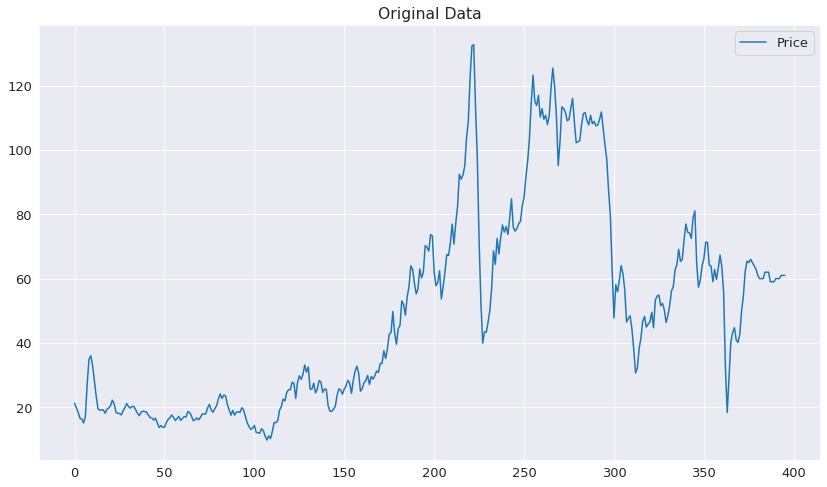

In [47]:
plt.plot(df1['Price'], label='Price')
plt.legend()
plt.title('Original Data')
plt.show()

----------------------------------------------------------------------------
- We can see mix trend but in the long run it is an increasing trend 
- Variance is also significant
- Seasonality is not so visible but lets decide it after STL decomposition
----------------------------------------------------------------------------

Q1) ii) Components of the data

In [22]:
from statsmodels.tsa.seasonal import STL
stl = STL(df, period=12)

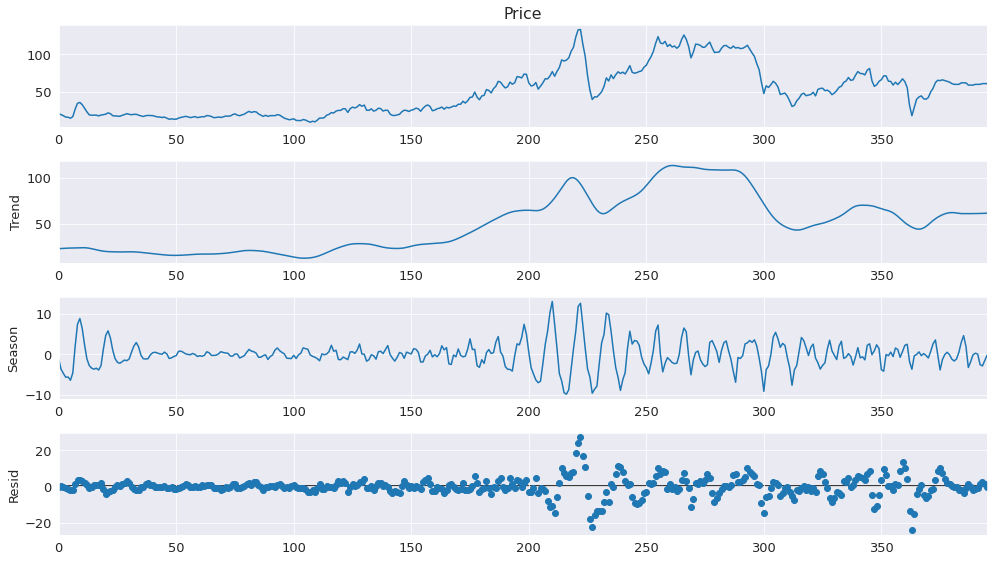

In [49]:
res = stl.fit()
fig = res.plot()

- There is gradual increase in trend
- No clear pattern can be seen in Seasonality so our initial observation was correct
- residuals are also random

Splitting the dataset into train and test

In [24]:
df.shape

(396,)

In [31]:
n=int(df.shape[0]*0.85) #test size=15% data
train=df.iloc[:n]
test=df.iloc[n:]


In [32]:
train.shape

(336,)

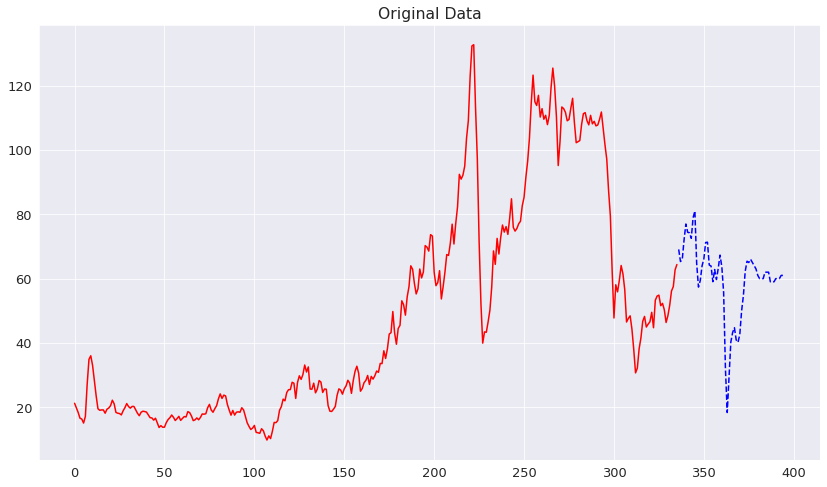

In [46]:
plt.title('Original Data')
plt.plot(train,'r')
plt.plot(test,'b--')

# **Q2) Stationarity Analysis**

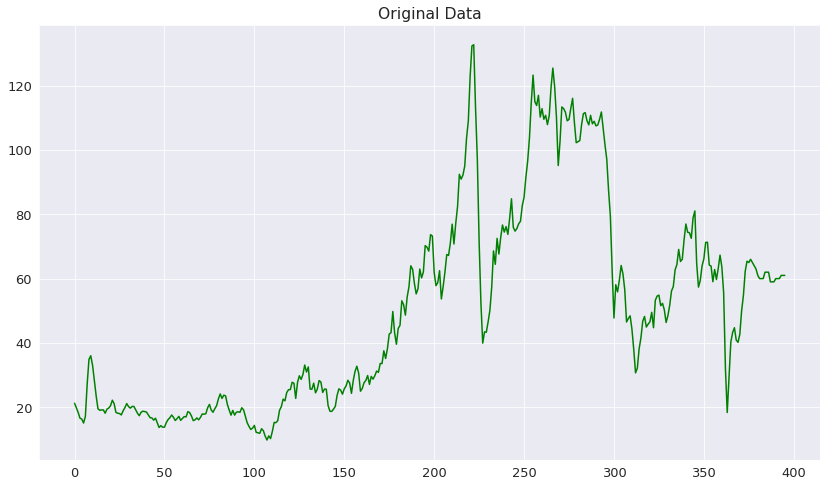

In [45]:
plt.title('Original Data')
plt.plot(df,'g')
plt.show()

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [36]:
dicky_fuller_test(df)

ADF Statistic: -2.366208
p-value: 0.151502
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Fail to reject the null hypothesis (H0), the data is non-stationary


- We can conclude that the data is non stationary as p- value is significantly greater than 0.05. 
- It means our initial observation was corrent that the data has varing mean and variance

- lets transform the data by differencing method to get rid of trend

In [41]:
df_diff1 = difference(df, interval=1)

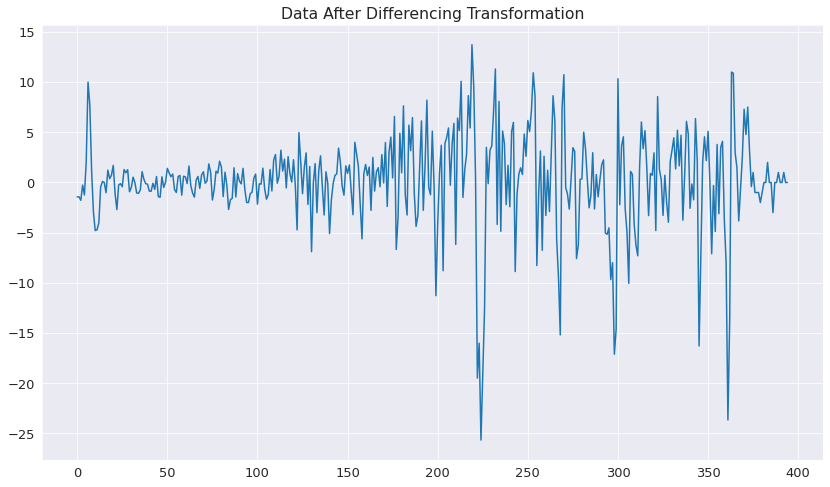

In [50]:
plt.title('Data After Differencing Transformation')
plt.plot(df_diff1)
plt.show()

In [43]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff1)

ADF Statistic: -13.287382
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Reject the null hypothesis (H0), the data is stationary.


- Our Data is now stationary as confirmed by the AD Fuller test, so differencing transformation has converted non-stationary data into stationary
- We can see from the above plot that the mean of the data is approximately same of any 2 given intervals 

# **Q3) ACF-PACF Plots**

-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


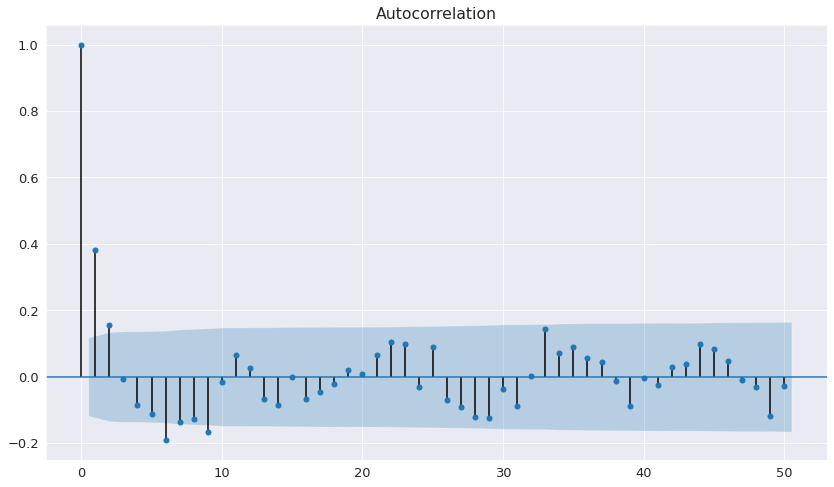

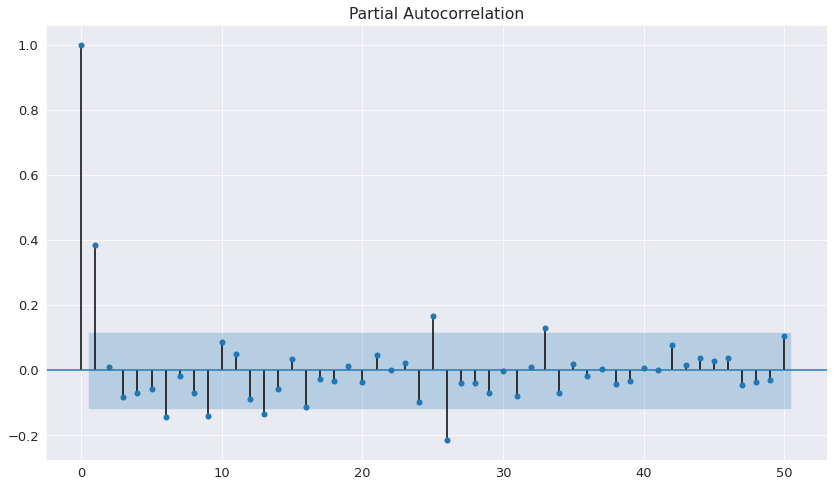

In [ ]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_diff1,lags=50)
fig2 = sm.graphics.tsa.plot_pacf(df_diff1,lags=50)

**Observations**
- From PACF plot we can say that p=1 as after lag 1 most for the lags are not significant since they lie inside the 95% confidence interval highlighted by the blue region
- From ACF plot q=2 almost or 1 as  second lag is very close to significance threshold region 
- d value would be 1 as we have differenced once to make the series stationary
- In SARIMA model P,D,Q,s =0 as no seasonality is present in the series
- **Also, we see Geometric decay in ACF plot and High degree of autocorrelation between adjacent (lag = 1) in PACF plot , so we can say that it is AR(p) process and MA(q) process is not required**

**Therefore, p=1,d=1,q=0**

# **Q4) ARIMA Models**

In [71]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(1,1,0)) # q=0 as only AR model is required 
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  336
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -964.798
Date:                Sat, 26 Nov 2022   AIC                           1933.597
Time:                        10:49:05   BIC                           1941.225
Sample:                             0   HQIC                          1936.638
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3777      0.028     13.732      0.000       0.324       0.432
sigma2        18.5720      0.904     20.553      0.000      16.801      20.343
Ljung-Box (L1) (Q):                   0.01   Jarque-

- Applying ARIMA with parameters p=1,d=1,q=1 to check weather our observation of only AR process is right or wrong 

In [73]:
# Applying ARIMA with parameters p=1,d=1,q=1
my_model2 = sm.tsa.arima.ARIMA(train, order=(1,1,1)) 
my_model_res2 = my_model2.fit()
print(my_model_res2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  336
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -964.779
Date:                Sat, 26 Nov 2022   AIC                           1935.559
Time:                        10:49:14   BIC                           1947.001
Sample:                             0   HQIC                          1940.120
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3989      0.076      5.254      0.000       0.250       0.548
ma.L1         -0.0247      0.098     -0.252      0.801      -0.217       0.168
sigma2        18.5690      0.905     20.518      0.0

- ma is not statistically significant as its p-value are above the 0.05 threshold.
- **This confirms that our observation about this time series being on AR is True as ar.L1 has p-value less than 0.05.**

In [74]:
pred_no=test.shape[0]
pred_no

60

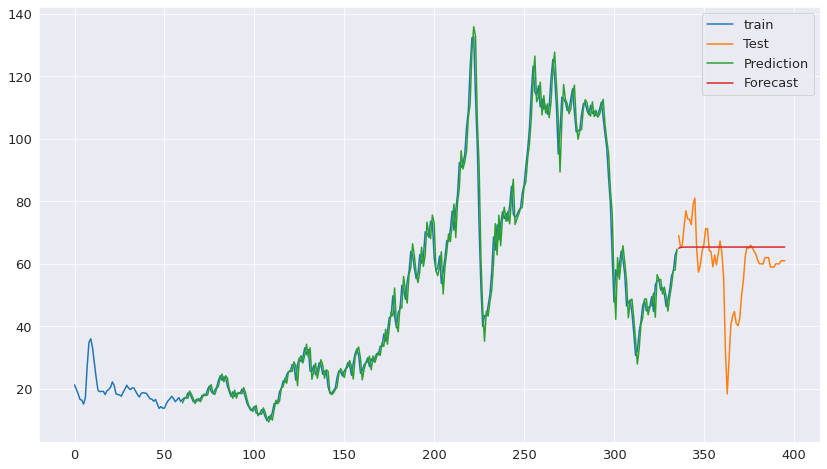

In [75]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is just a straight line because seasonality wasn’t taken into consideration.

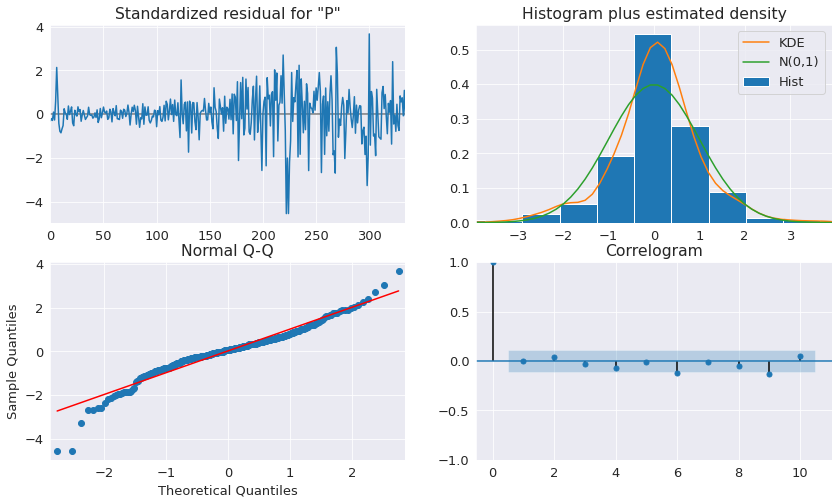

In [76]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
test.shape

(60,)

In [79]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

12.83557916390619

In [80]:
tsforecast.describe()

count    60.000000
mean     65.371165
std       0.052494
min      65.000916
25%      65.381354
50%      65.381354
75%      65.381354
max      65.381354
Name: predicted_mean, dtype: float64

In [81]:
pd.DataFrame({'Actual Values':test,'Forecasted_Values':tsforecast})

,Actual Values,Forecasted_Values
336,69.077,65.000916
337,65.318,65.237678
338,66.017,65.327093
339,72.106,65.360862
340,76.975,65.373615
341,74.405,65.378431
342,74.254,65.380250
343,72.528,65.380937
344,78.891,65.381196
345,81.032,65.381294


# lets predict values on original data

In [84]:
# Applying ARIMA with parameters p=1,d=1,q=0
my_model3 = sm.tsa.arima.ARIMA(df, order=(1,1,0)) 
my_model_res3 = my_model3.fit()
print(my_model_res3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  396
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1151.151
Date:                Sat, 26 Nov 2022   AIC                           2306.302
Time:                        10:50:44   BIC                           2314.260
Sample:                             0   HQIC                          2309.455
                                - 396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3785      0.027     14.232      0.000       0.326       0.431
sigma2        19.8925      0.836     23.800      0.000      18.254      21.531
Ljung-Box (L1) (Q):                   0.26   Jarque-

- the Prob(Q) is 0.61. Since the probability is above 0.05, we can’t reject the null that the errors are white noise.

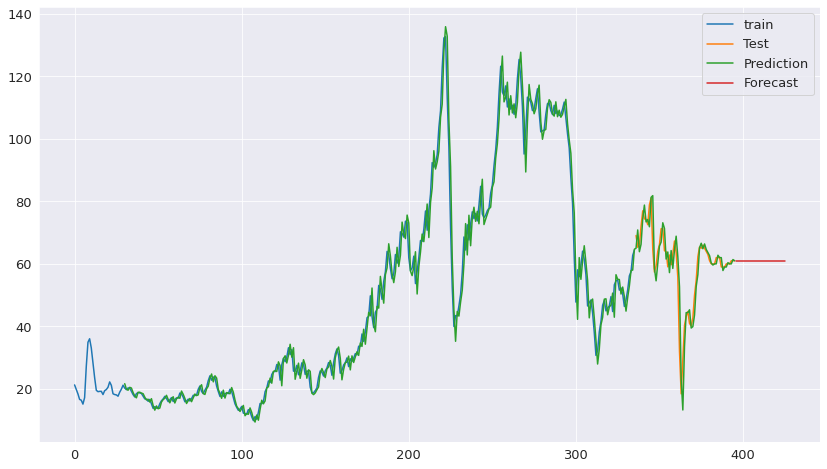

In [86]:
#predicting and forecast on train and test data

tspredict= my_model_res3.predict(30)

tsforecast=my_model_res3.forecast(30)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is just a straight line because seasonality wasn’t taken into consideration.

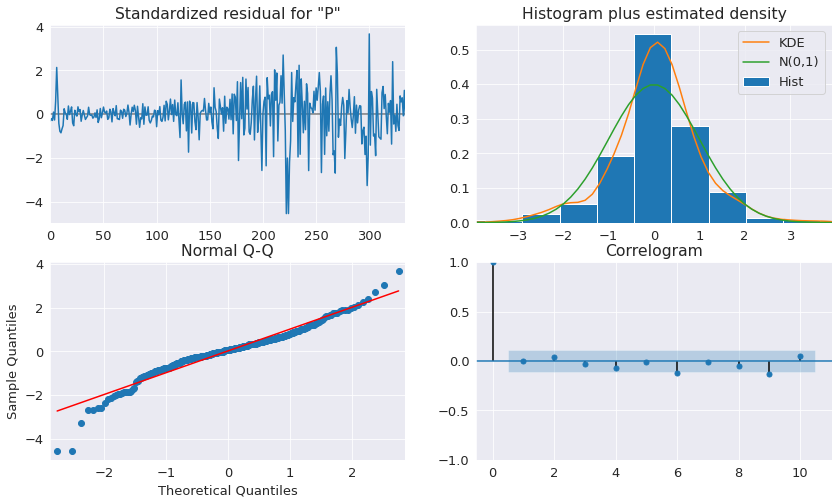

In [87]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



# **Holt-Winter**

**Q5) Naive Holt-winter Model ie simple exponential smoothing**

In [88]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [89]:
ses = SimpleExpSmoothing(df)

In [99]:
result = ses.fit(smoothing_level=0.3, optimized=False)

In [105]:
print(result.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Price   No. Observations:                  396
Model:             SimpleExpSmoothing   SSE                          26235.547
Optimized:                      False   AIC                           1664.609
Trend:                           None   BIC                           1672.572
Seasonal:                        None   AICC                          1664.711
Seasonal Periods:                None   Date:                 Sat, 26 Nov 2022
Box-Cox:                        False   Time:                         11:06:09
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000                alpha                False
initial_level              21.251000                

In [111]:
mypred = result.predict(start=1, end=450)

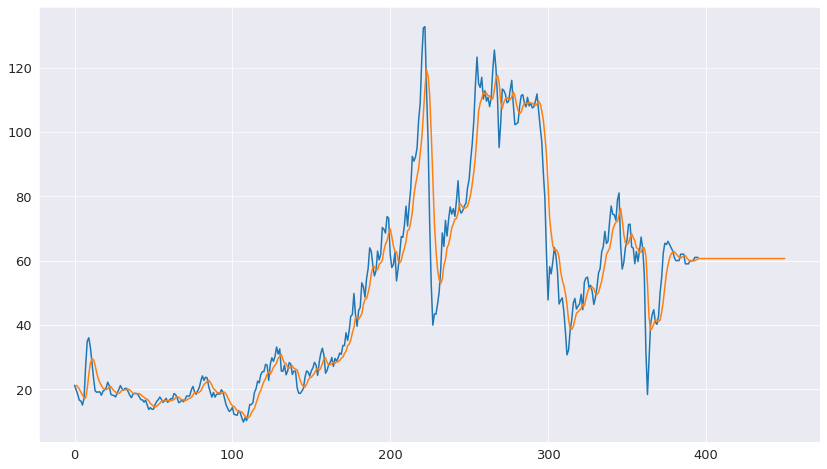

In [112]:
plt.plot(df)
plt.plot(mypred)

In [113]:
forecast_naive=result.predict(start=df.shape[0], end=450)

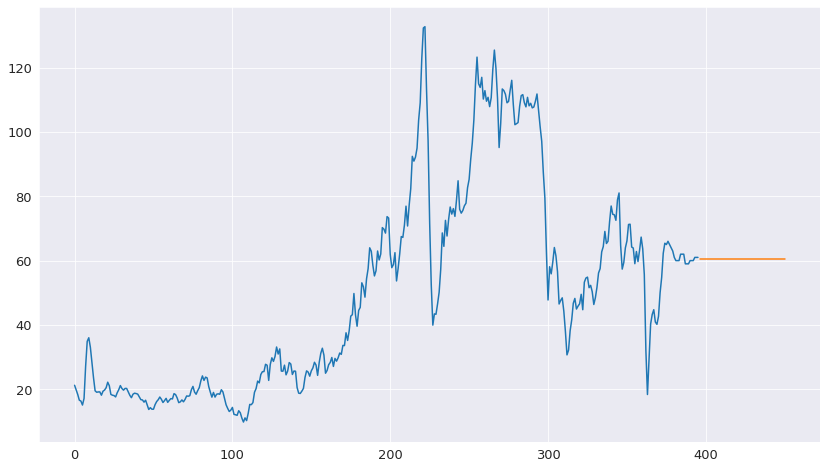

In [114]:
plt.plot(df)
plt.plot(forecast_naive)

In [116]:
forecast_naive

396    60.64332
397    60.64332
398    60.64332
399    60.64332
400    60.64332
401    60.64332
402    60.64332
403    60.64332
404    60.64332
405    60.64332
406    60.64332
407    60.64332
408    60.64332
409    60.64332
410    60.64332
411    60.64332
412    60.64332
413    60.64332
414    60.64332
415    60.64332
416    60.64332
417    60.64332
418    60.64332
419    60.64332
420    60.64332
421    60.64332
422    60.64332
423    60.64332
424    60.64332
425    60.64332
426    60.64332
427    60.64332
428    60.64332
429    60.64332
430    60.64332
431    60.64332
432    60.64332
433    60.64332
434    60.64332
435    60.64332
436    60.64332
437    60.64332
438    60.64332
439    60.64332
440    60.64332
441    60.64332
442    60.64332
443    60.64332
444    60.64332
445    60.64332
446    60.64332
447    60.64332
448    60.64332
449    60.64332
450    60.64332
dtype: float64

- We can see that our naive model has given a flat line prediction
- this is because it is just based on simple moving average method and no trend or seasonality has been considered 

# **Q6) Holt-winter model for trend i.e. Holt model**

In [117]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [118]:
model = Holt(df)
result = model.fit()
result.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 20.901717134607043,
 'initial_trend': 0.10078526710922137,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [119]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                  Price   No. Observations:                  396
Model:                           Holt   SSE                           9174.795
Optimized:                       True   AIC                           1252.549
Trend:                       Additive   BIC                           1268.475
Seasonal:                        None   AICC                          1252.765
Seasonal Periods:                None   Date:                 Sat, 26 Nov 2022
Box-Cox:                        False   Time:                         11:17:10
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.000000                

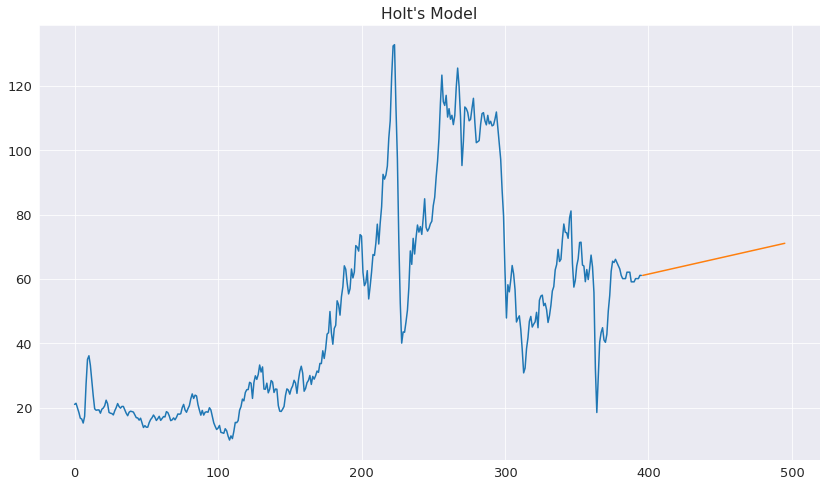

In [121]:
plt.title("Holt's Model")
plt.plot(result.fittedvalues)
plt.plot(result.forecast(100))

lets check on training data and compare values

In [124]:
model2 = Holt(train)
result2 = model.fit()
result2.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 21.12225741717364,
 'initial_trend': 0.12872536720061467,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

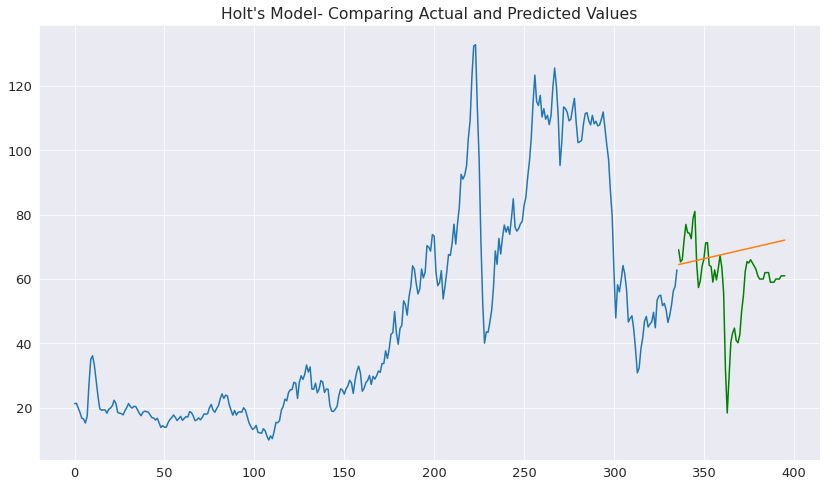

In [130]:
plt.title("Holt's Model- Comparing Actual and Predicted Values")
plt.plot(result2.fittedvalues)
plt.plot(test, 'g')
plt.plot(result2.forecast(test.shape[0]))
plt.show()

In [131]:
rmse = mean_squared_error(test, result2.forecast(test.shape[0]), squared=False)
rmse

14.98108164526095

**OBSERVATIONS**
- Holt's model has predited a increasing trend line based on the recent past values
- It has considered moving average and trend to predict these values

# Q7) Holt-Winter Model- Triple Exponential Smoothing

In [133]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [136]:
model = ExponentialSmoothing(df, trend='add', seasonal='add', seasonal_periods=12)

In [137]:
result3 = model.fit()
result3.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 4.959907820607296e-10,
 'damping_trend': nan,
 'initial_level': 23.230368585382514,
 'initial_trend': 0.10094437732966995,
 'initial_seasons': array([-2.0684953 , -1.2075501 , -0.64187077, -0.00644104,  0.8310001 ,
         0.82613822,  1.48882589,  1.41673323,  1.27298814,  0.37808142,
        -1.14051568, -2.16016126]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

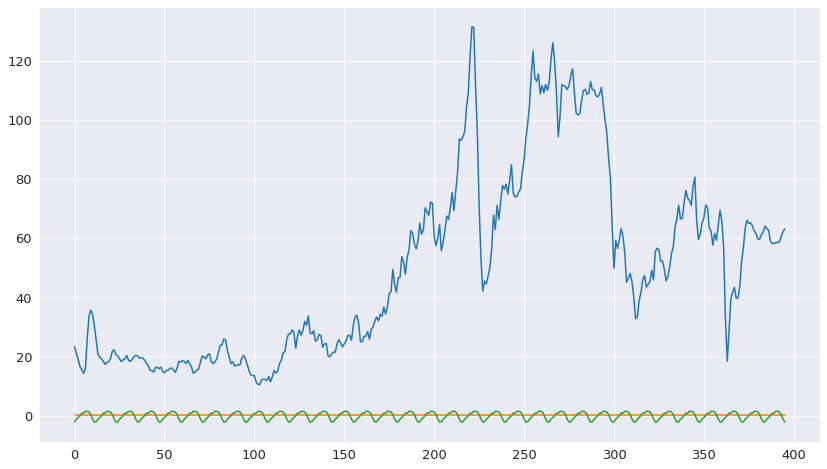

In [138]:
plt.plot(result3.level)
plt.plot(result3.trend)
plt.plot(result3.season)

In [139]:
print(result3.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  396
Model:             ExponentialSmoothing   SSE                           8951.229
Optimized:                         True   AIC                           1266.780
Trend:                         Additive   BIC                           1330.483
Seasonal:                      Additive   AICC                          1268.595
Seasonal Periods:                    12   Date:                 Sat, 26 Nov 2022
Box-Cox:                          False   Time:                         11:29:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

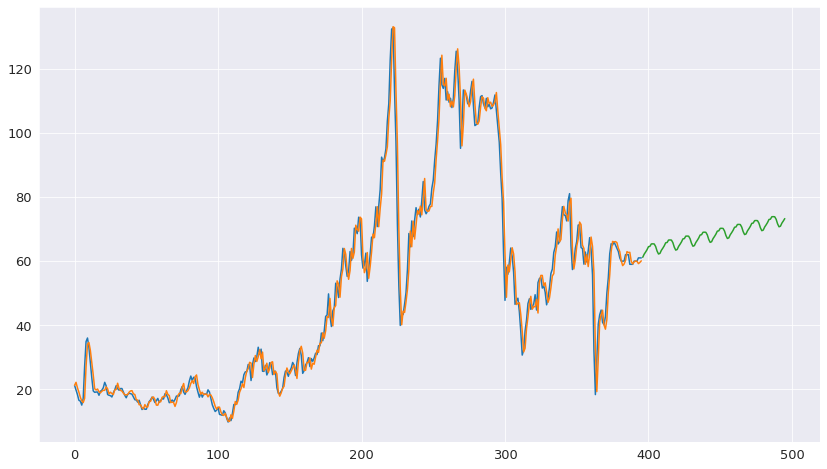

In [140]:
plt.plot(df)
plt.plot(result3.fittedvalues)
plt.plot(result3.forecast(100))

- Holt-winter model has predicted a trend line with seasonality

predictions of full winter's model

In [141]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)

In [143]:
result3 = model.fit()
result3.params

{'smoothing_level': 0.9999992052044065,
 'smoothing_trend': 8.762987699735551e-07,
 'smoothing_seasonal': 2.2316709827834507e-07,
 'damping_trend': nan,
 'initial_level': 23.639996103733118,
 'initial_trend': 0.12754178673499766,
 'initial_seasons': array([-2.65560829, -1.66582181, -0.38062938,  0.56766538,  0.93374531,
         0.91509061,  1.60245075,  1.73190796,  1.39449939,  0.39284304,
        -1.03825655, -2.39311367]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

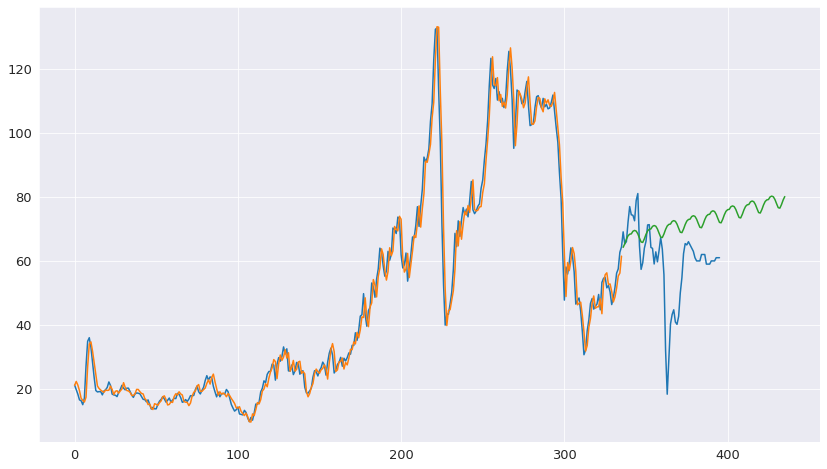

In [145]:
plt.plot(df)
plt.plot(result3.fittedvalues)
plt.plot(result3.forecast(100))
plt.show()

In [146]:
rmse = mean_squared_error(test, result3.forecast(test.shape[0]), squared=False)
rmse

16.449563753858573

# **Q8) Comparisions of the Models**

**Observations**
- ARIMA Model


```
1.   AIC value = 1935
2.   RMSE Value =12.83


```
- Full Winter-Holt's

```
1.   AIC value= 1266
2.   RMSE value= 16.44





- We can see that as per STL decompose and ARIMA model we have no seasonality in the Data, and based on ARMIA predicted values on the train data, we got rmse value of 12.83 when actual and predicted values were compared
- Where as for full Holt-winter's model, rmse value is 16.44
- So if we consider rmse as metrics ARIMA performed better than full holt'winter model
- if goodness of fit is considered, as per AIC value, AIC for holt winter is 1266 which is less that AIC of ARIMA model. So Holt'winter model fits better on the data
